In [1]:
from google.cloud import storage
import pandas as pd
import pyarrow.parquet as pq
import io
import ast
import numpy as np
import koreanize_matplotlib
import matplotlib.dates as mdates
from matplotlib.colors import LinearSegmentedColormap

# 한글 깨짐 방지 (옵션)
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.family'] = 'NanumGothic'  # Windows # 나눔고딕 가능
plt.rcParams['axes.unicode_minus'] = False     # 마이너스 부호 깨짐 방지

In [2]:
client = storage.Client()

bucket_name = 'sprint_project4'
file_path = "sprint_project4/votes"

bucket = client.bucket(bucket_name)
blob = bucket.blob(file_path)

# 1. EDA

## 1-1. accounts_attendance(출석)

In [3]:
blob = bucket.blob('votes/accounts_attendance.parquet')
parquet_bytes = blob.download_as_bytes()
attendance = pd.read_parquet(io.BytesIO(parquet_bytes))
attendance.head()

,id,attendance_date_list,user_id
0,1,"[""2023-05-27"", ""2023-05-28"", ""2023-05-29"", ""20...",1446852
1,2,"[""2023-05-27"", ""2023-05-29"", ""2023-05-30"", ""20...",1359398
2,3,"[""2023-05-27"", ""2023-05-29"", ""2023-05-30"", ""20...",1501542
3,4,"[""2023-05-27"", ""2023-05-28"", ""2023-05-29"", ""20...",1507767
4,5,"[""2023-05-27"", ""2023-05-28"", ""2023-05-29"", ""20...",1287453


In [4]:
# 사용 데이터 기간 2023년 5,6,7월

# 출석 횟수를 알아보자
attendance_df = attendance.copy()

# attendance_date_list 리스트 변환
attendance_df['attendance_date_list'] = attendance_df['attendance_date_list'].apply(ast.literal_eval)

# 출석 횟수 계산
attendance_df['attendance_count'] = attendance_df['attendance_date_list'].apply(len)

print(attendance_df[['user_id', 'attendance_count']])

        user_id  attendance_count
0       1446852                13
1       1359398                33
2       1501542                 9
3       1507767                30
4       1287453                31
...         ...               ...
349632   897005                 0
349633  1407059                 1
349634  1583727                 1
349635  1392372                 1
349636  1583730                 1

[349637 rows x 2 columns]


In [5]:
# 월별 출석 확인 횟수 확인

# explode로 풀어서 하나의 row로
attendance_exploded = attendance_df.explode('attendance_date_list')
attendance_exploded

# attendance_date_list datetime으로 형식 변경 => 결측 NaT
attendance_exploded['attendance_date_list'] = pd.to_datetime(attendance_exploded['attendance_date_list'])
attendance_exploded

,id,attendance_date_list,user_id,attendance_count
0,1,2023-05-27,1446852,13
0,1,2023-05-28,1446852,13
0,1,2023-05-29,1446852,13
0,1,2023-05-30,1446852,13
0,1,2023-06-03,1446852,13
...,...,...,...,...
349632,360501,NaT,897005,0
349633,360502,2024-05-09,1407059,1
349634,360503,2024-05-09,1583727,1
349635,360504,2024-05-09,1392372,1


In [6]:
attendance_exploded['month'] = attendance_exploded['attendance_date_list'].dt.month
attendance_exploded['year'] = attendance_exploded['attendance_date_list'].dt.year

attendance_filtered = attendance_exploded[
    (attendance_exploded['year'] == 2023) &
    (attendance_exploded['month'].isin([5,6,7]))
].copy()

attendance_filtered['month'] = attendance_filtered['month'].astype(int)
attendance_filtered['year'] = attendance_filtered['year'].astype(int)
attendance_filtered

display(attendance_filtered)

attendance_count = attendance_filtered.groupby(['user_id', 'month']).size().reset_index(name='attendance_count')

,id,attendance_date_list,user_id,attendance_count,month,year
0,1,2023-05-27,1446852,13,5,2023
0,1,2023-05-28,1446852,13,5,2023
0,1,2023-05-29,1446852,13,5,2023
0,1,2023-05-30,1446852,13,5,2023
0,1,2023-06-03,1446852,13,6,2023
...,...,...,...,...,...,...
339377,350175,2023-07-31,1390952,2,7,2023
339378,350176,2023-07-31,1537582,1,7,2023
339379,350177,2023-07-31,1345721,1,7,2023
339380,350178,2023-07-31,1307547,1,7,2023


In [7]:
# 5,6,7 월별 출석휫수 시각화
monthly_attendance = attendance_count.groupby('month')['attendance_count'].sum().reset_index()
monthly_attendance.columns = ['월', '출석횟수']
monthly_attendance = monthly_attendance.sort_values('월')  # 월별 정렬
monthly_attendance

,월,출석횟수
0,5,611238
1,6,1232776
2,7,200306


In [8]:
# 피봇 테이블 형성 -> 더 보기 좋게
attendance_pivot = attendance_count.pivot(index='user_id', columns='month', values='attendance_count').fillna(0).astype(int)
attendance_pivot.columns = [f'{month}월' for month in attendance_pivot.columns]
attendance_pivot

,5월,6월,7월
user_id,,,
832151,1,0,0
832340,0,2,0
832986,1,0,0
833041,5,9,18
833154,1,0,0
...,...,...,...
1579618,0,0,1
1579623,0,0,1
1579628,0,0,1


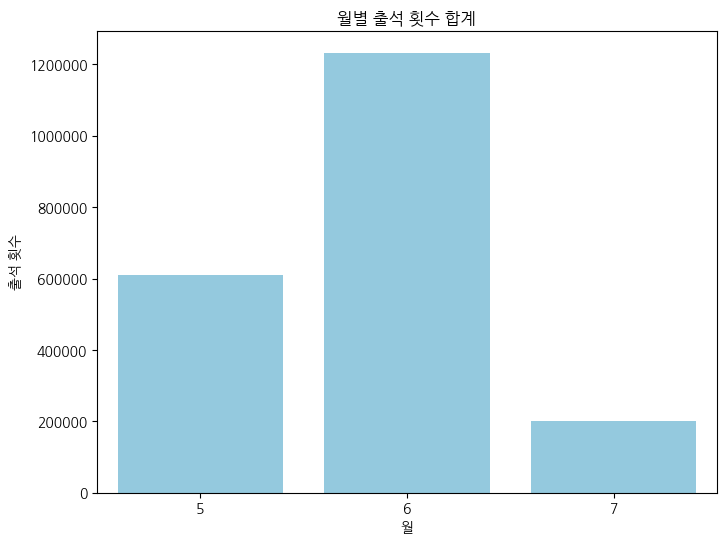

In [9]:
# 월별 누적 출석 횟수 시각화
plt.figure(figsize=(8, 6))
sns.barplot(x='월', y='출석횟수', data=monthly_attendance, color='skyblue')
plt.xlabel('월')
plt.ylabel('출석 횟수')
plt.title('월별 출석 횟수 합계')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

,월,출석횟수,전체출석횟수,출석률
0,5,611238,2044320,29.899331
1,6,1232776,2044320,60.302497
2,7,200306,2044320,9.798172


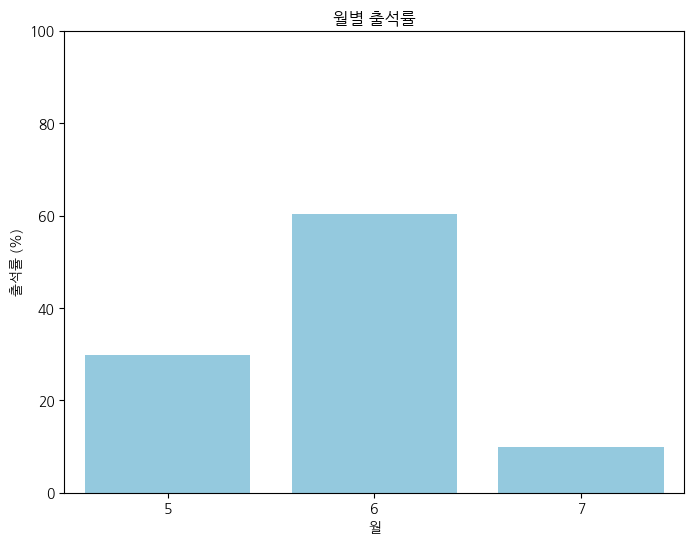

In [10]:
# 월별 누적 출석률 시각화

# 월별 사용자 수 집계
monthly_attendance['전체출석횟수'] = monthly_attendance['출석횟수'].sum()
monthly_attendance['출석률'] = (monthly_attendance['출석횟수'] / monthly_attendance['전체출석횟수']) * 100
display(monthly_attendance)

# 시각화
plt.figure(figsize=(8, 6))
sns.barplot(x='월', y='출석률', data=monthly_attendance, color='skyblue')
plt.xlabel('월')
plt.ylabel('출석률 (%)')
plt.title('월별 출석률')
plt.ylim(0, 100)
plt.ticklabel_format(style='plain', axis='y')
plt.show()

In [11]:
# 주차 계산
attendance_filtered['week'] =attendance_filtered['attendance_date_list'].dt.isocalendar().week
attendance_filtered

,id,attendance_date_list,user_id,attendance_count,month,year,week
0,1,2023-05-27,1446852,13,5,2023,21
0,1,2023-05-28,1446852,13,5,2023,21
0,1,2023-05-29,1446852,13,5,2023,22
0,1,2023-05-30,1446852,13,5,2023,22
0,1,2023-06-03,1446852,13,6,2023,22
...,...,...,...,...,...,...,...
339377,350175,2023-07-31,1390952,2,7,2023,31
339378,350176,2023-07-31,1537582,1,7,2023,31
339379,350177,2023-07-31,1345721,1,7,2023,31
339380,350178,2023-07-31,1307547,1,7,2023,31


In [12]:
wau_df = (
    attendance_filtered
    .groupby(['week'])['user_id']
    .nunique()
    .reset_index(name='WAU')
)
wau_df

,week,WAU
0,21,130312
1,22,273432
2,23,148277
3,24,76798
4,25,60000
5,26,32390
6,27,21902
7,28,26215
8,29,22174
9,30,19015


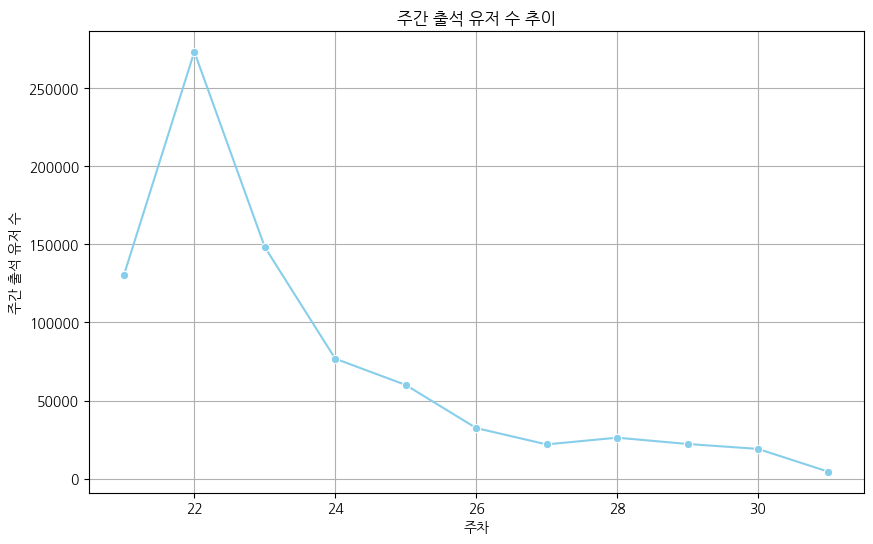

In [13]:
# 그래프 그리기
plt.figure(figsize=(10, 6))
sns.lineplot(data=wau_df, x='week', y='WAU', marker='o', color='skyblue')
plt.xlabel('주차')
plt.ylabel('주간 출석 유저 수')
plt.title('주간 출석 유저 수 추이')
plt.grid(True)
plt.show()

   attendance_date_list  daily_active_users
0            2023-05-27               62417
1            2023-05-28               94220
2            2023-05-29              172836
3            2023-05-30              166052
4            2023-05-31              115713
..                  ...                 ...
61           2023-07-27                5799
62           2023-07-28                5972
63           2023-07-29                6047
64           2023-07-30                4723
65           2023-07-31                4405

[66 rows x 2 columns]


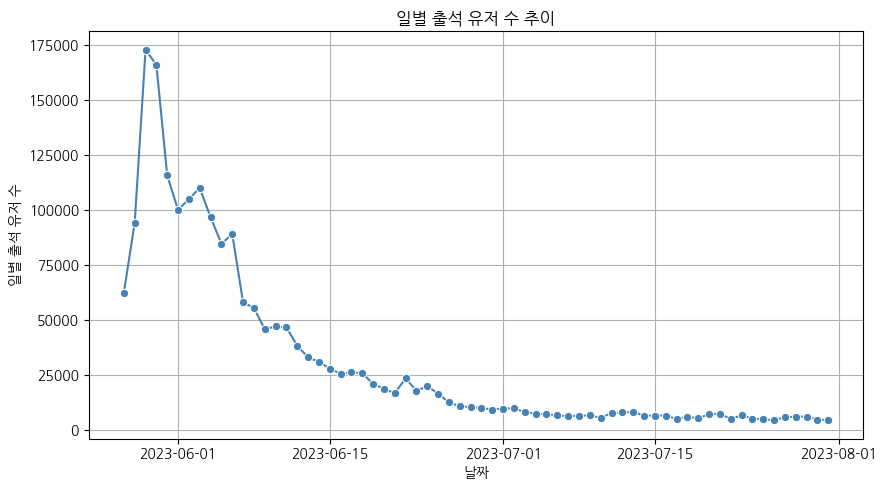

In [14]:
daily_attendance = (
    attendance_filtered
    .groupby('attendance_date_list')['user_id']
    .nunique()
    .reset_index(name='daily_active_users')
)
print(daily_attendance)

# 일별 출석 유저 수
plt.figure(figsize=(9, 5))
sns.lineplot(
    data=daily_attendance,
    x='attendance_date_list',
    y='daily_active_users',
    marker='o',
    color='steelblue'
)
plt.xlabel('날짜')
plt.ylabel('일별 출석 유저 수')
plt.title('일별 출석 유저 수 추이')
plt.grid(True)
plt.tight_layout()
plt.show()

## 1-2. accounts_user(유저)
- is_superuser : superuser 여부
- is_staff : staff 여부
- firebase_id : 과거 firebase 세션 관리 할 때 사용하는 식별자(이 컬럼은 제거 예정)
- friend_id_list : 친구 id 데이터
- block_user_id_list : 차단한 유저 id 데이터
- hide_user_id_list : 숨김 처리한 유저 id 데이터
- ban_status : 차단 혹은 탈퇴한 유저인지 타입
- report_count : 신고 당한 횟수
- alarm_count : 알람 갯수
- pending_chat: 안읽은 채팅 개수
- pending_votes : 확인 안한 투표 개수

In [15]:
blob = bucket.blob('votes/accounts_user.parquet')
parquet_bytes = blob.download_as_bytes()
user = pd.read_parquet(io.BytesIO(parquet_bytes))
user.head()

,id,is_superuser,is_staff,gender,point,friend_id_list,is_push_on,created_at,block_user_id_list,hide_user_id_list,ban_status,report_count,alarm_count,pending_chat,pending_votes,group_id
0,831956,1,1,None,600,"[1292473, 913158, 1488461, 1064695, 1043565, 1...",0,2023-03-29 03:44:14.047130,[],[],N,0,0,0,0,NaN
1,831962,0,0,F,2248,"[833025, 832642, 982531, 879496, 838541, 83752...",1,2023-03-29 05:18:56.162368,[],[],N,253,40878,5499,110,12.0
2,832151,0,0,M,1519,"[838785, 982531, 882567, 879496, 838541, 83649...",0,2023-03-29 12:56:34.989468,[],[],N,0,37,0,47,1.0
3,832340,0,0,F,57,"[841345, 982531, 838785, 963714, 882567, 83252...",1,2023-03-29 12:56:35.020790,[],[],N,0,19,0,21,1.0
4,832520,0,0,M,1039,"[874050, 849763, 874212, 844297, 838541, 84004...",0,2023-03-29 12:56:35.049311,[],[],N,0,29,0,15,12.0


In [16]:
user_df = user.copy()

# 사용 데이터 기간 5,6,7월
user_df = user[
    (user['created_at'].dt.year == 2023) &
    (user['created_at'].dt.month.isin([5, 6, 7]))
]
user_df.head()

,id,is_superuser,is_staff,gender,point,friend_id_list,is_push_on,created_at,block_user_id_list,hide_user_id_list,ban_status,report_count,alarm_count,pending_chat,pending_votes,group_id
13302,855179,0,0,M,1358,"[849767, 850569, 857770, 856249, 850108, 869470]",1,2023-05-18 16:36:23.667542,[],[],N,0,1,0,23,5532.0
19094,862517,0,0,F,1391,"[880775, 838285, 868495, 875156, 838421, 83842...",1,2023-05-01 00:00:12.942200,[],[],N,0,1,0,19,6337.0
19095,862518,0,0,F,1063,"[857473, 846981, 860934, 858247, 859913, 86901...",1,2023-05-01 00:00:22.647793,[],[],N,0,0,0,61,7020.0
19096,862519,0,0,F,2137,"[1215494, 1150344, 1520776, 1160844, 1090445, ...",0,2023-05-01 00:00:32.161347,[],[],N,0,2,0,180,7392.0
19097,862520,0,0,M,2838,"[874368, 856706, 1407234, 982788, 1145859, 100...",1,2023-05-01 00:00:48.974195,[],[],N,0,1,0,190,3526.0


In [17]:
# created_at 기준 각 일별 사용자 가입자 수 변화

user_df['created_date'] = user_df['created_at'].dt.date

daily_users = user_df.groupby('created_date')['id'].nunique().reset_index()

daily_users.columns = ['date', 'user_count']

daily_users

/tmp/ipykernel_2968146/3719068871.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_df['created_date'] = user_df['created_at'].dt.date


,date,user_count
0,2023-05-01,4640
1,2023-05-02,4071
2,2023-05-03,4231
3,2023-05-04,3473
4,2023-05-05,6334
...,...,...
87,2023-07-27,33
88,2023-07-28,31
89,2023-07-29,25
90,2023-07-30,15


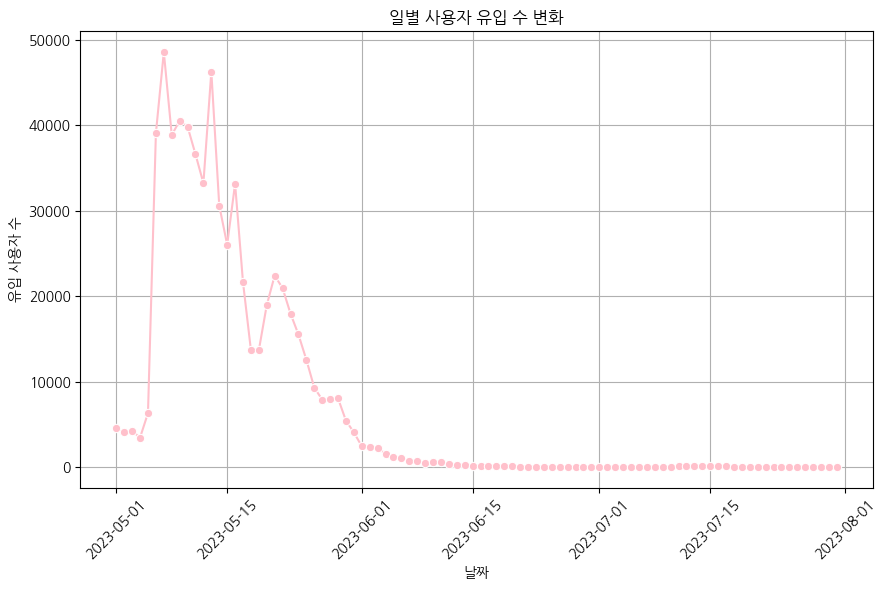

In [ ]:
# 일별 회원가입 유저 수 시각화
plt.figure(figsize=(9, 6))
sns.lineplot(x='date', y='user_count', data=daily_users, marker='o', color = 'pink')
plt.title('일별 사용자 유입 수 변화')
plt.xlabel('날짜')
plt.ylabel('유입 사용자 수')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

## 1-3. accounts_userquestionrecord(투표기록)
- status : 상태(C : closed(닫힘), I : initial(초성 열림), B: blocked(차단))
- chosen_user_id : 선택 받은 유저 id
- opened_times : 열어본 횟수
- question_id : 질문 id
- question_piece_id : 투표 id
- answer_status : 답장 상태(N : 미답변, P : 비공개, A : 공개)
- answer_updated_at : 답장 시간
- report_count : 신고 횟수
- has_read : 읽었는지 여부

In [19]:
blob = bucket.blob('votes/accounts_userquestionrecord.parquet')
parquet_bytes = blob.download_as_bytes()
userquestionrecord = pd.read_parquet(io.BytesIO(parquet_bytes))
userquestionrecord.head()

,id,status,created_at,chosen_user_id,question_id,user_id,question_piece_id,has_read,answer_status,answer_updated_at,report_count,opened_times
0,771777,C,2023-04-28 12:27:49,849469,252,849436,998458,0,N,2023-04-28 12:27:49,0,0
1,771800,C,2023-04-28 12:28:02,849446,244,849436,998459,0,N,2023-04-28 12:28:02,0,0
2,771812,C,2023-04-28 12:28:09,849454,183,849436,998460,1,N,2023-04-28 12:28:09,0,0
3,771828,C,2023-04-28 12:28:16,847375,101,849436,998461,0,N,2023-04-28 12:28:16,0,0
4,771851,C,2023-04-28 12:28:26,849477,209,849436,998462,1,N,2023-04-28 12:28:26,0,0


In [20]:
# 사용 데이터 기간 5,6,7월
userquestionrecord_df = userquestionrecord[
    (userquestionrecord['created_at'].dt.year == 2023) &
    (userquestionrecord['created_at'].dt.month.isin([5, 6, 7]))
]
userquestionrecord_df

,id,status,created_at,chosen_user_id,question_id,user_id,question_piece_id,has_read,answer_status,answer_updated_at,report_count,opened_times
30798,1481996,C,2023-05-01 03:37:42,855817,202,857913,1821408,0,N,2023-05-01 03:37:42,0,0
30799,1482200,C,2023-05-01 03:38:24,855549,116,856430,1861799,0,N,2023-05-01 03:38:24,0,0
30800,1482273,C,2023-05-01 03:38:38,855509,199,856430,1861800,0,N,2023-05-01 03:38:38,0,0
30801,1482321,C,2023-05-01 03:38:48,855509,238,856430,1861801,0,N,2023-05-01 03:38:48,0,0
30802,1482347,C,2023-05-01 03:38:53,860439,190,856430,1861802,0,N,2023-05-01 03:38:53,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1212211,160262886,C,2023-07-31 16:06:08,859802,1653,866250,187023487,0,N,2023-07-31 16:06:08,0,0
1212212,160262893,C,2023-07-31 16:06:14,850774,1967,866250,187023488,0,N,2023-07-31 16:06:14,0,0
1212213,160262898,C,2023-07-31 16:06:19,1205810,2948,866250,187023489,0,N,2023-07-31 16:06:19,0,0
1212214,160262908,I,2023-07-31 16:06:28,865846,2253,866250,187023490,1,N,2023-07-31 16:06:28,0,2


## 1-4. polls_question(질문 데이터)

In [21]:
blob = bucket.blob('votes/polls_question.parquet')
parquet_bytes = blob.download_as_bytes()
polls_question = pd.read_parquet(io.BytesIO(parquet_bytes))
polls_question.head()

,id,question_text,created_at
0,99,가장 신비한 매력이 있는 사람은?,2023-03-31 15:22:53
1,100,"""이 사람으로 한 번 살아보고 싶다"" 하는 사람은?",2023-03-31 15:22:53
2,101,미래의 틱톡커는?,2023-03-31 15:22:54
3,102,여기서 제일 특이한 친구는?,2023-03-31 15:22:54
4,103,가장 지켜주고 싶은 사람은?,2023-03-31 15:22:55


In [22]:
# 생성된 질문 수 => 3903개(질문 생성 날짜 : 2023년 3월 31일 ~ 2023년 06월 06일)
m_question = polls_question['question_text'].value_counts().reset_index()
m_question

,question_text,count
0,vote,56
1,인생 2회차인 것 같은 사람은?,3
2,2세가 가장 귀여울 것 같은 사람은?,3
3,눈이 제일 큰 사람은?,3
4,지금 뭐하는지 궁금한 친구,3
...,...,...
3898,장기자랑 1등 할 것 같은 친구는?,1
3899,키가 제일 클 것 같은 사람은?,1
3900,한번쯤 예쁘다고 생각해본 사람은?,1
3901,인스타 부계가 가장 맛깔나는 친구는?,1


In [23]:
# 질문 생성 시기

# created_at 컬럼을 datetime 형식으로 변환 후 date만 추출
polls_question['created_at'] = pd.to_datetime(polls_question['created_at']).dt.date

# 날짜별 value_counts
date_counts = polls_question['created_at'].value_counts().sort_index()

date_counts.reset_index()

,created_at,count
0,2023-03-31,73
1,2023-04-01,154
2,2023-05-02,235
3,2023-05-04,1
4,2023-05-11,91
5,2023-05-15,982
6,2023-06-02,1523
7,2023-06-06,1966


## 1-5. accounts_group(학급 테이블)

In [30]:
blob = bucket.blob('votes/accounts_group.parquet')
parquet_bytes = blob.download_as_bytes()
group = pd.read_parquet(io.BytesIO(parquet_bytes))
group.head()

,id,grade,class_num,school_id
0,1,1,1,1
1,8,3,2,1
2,9,3,3,1
3,10,2,2,1
4,11,2,3,1


In [31]:
group['grade'].value_counts()

grade
2     35581
3     29273
1     19659
4         1
20        1
Name: count, dtype: int64

In [32]:
group['class_num'].value_counts()

class_num
1     12125
2     11077
3     10276
4      9506
5      8578
6      7555
7      6390
8      5294
9      3799
10     3067
20     2454
11     1600
12      998
13      506
14      311
18      217
15      216
17      214
19      177
16      152
0         2
41        1
Name: count, dtype: int64

In [33]:
# grade와 class_num 이상치 제거
# group_df = group.copy()

group_df = group[(~group['grade'].isin([4,20])) & (~group['class_num'].isin([0,41]))]
group_df

,id,grade,class_num,school_id
0,1,1,1,1
1,8,3,2,1
2,9,3,3,1
3,10,2,2,1
4,11,2,3,1
...,...,...,...,...
84510,84542,3,2,5107
84511,84543,2,7,3487
84512,84544,3,1,5043
84513,84545,2,7,416


In [35]:
print("학교 수")
group_df['school_id'].nunique()

학교 수


5604

In [34]:
# 학교별 -> 학년별 -> 반 학생 수 -> 각 학교 서비스 가입 전체 학생 수
# 반별 학생 수
group_counts = group_df.groupby(['school_id', 'grade', 'class_num']).size().reset_index(name='user_counts')

# 학교별 전체 학생 수
school_counts = group_df.groupby('school_id').size().reset_index(name='school_total_user_count')

# 병합
group_counts = group_counts.merge(school_counts, on='school_id', how='left')

group_counts

,school_id,grade,class_num,user_counts,school_total_user_count
0,1,1,1,1,26
1,1,1,2,1,26
2,1,1,3,1,26
3,1,1,4,1,26
4,1,1,5,1,26
...,...,...,...,...,...
84500,5965,1,10,1,7
84501,5965,1,19,1,7
84502,5965,2,1,1,7
84503,5965,2,5,1,7


In [36]:
group_counts.sort_values(by = 'school_total_user_count', ascending = False)
# 각 학교별 총 이용자 수
school_user_counts = group_counts.groupby('school_id')['school_total_user_count'].first().reset_index()
school_user_counts = school_user_counts.sort_values(by = 'school_total_user_count', ascending = False)
school_user_counts

,school_id,school_total_user_count
3108,3283,49
1646,1773,44
1380,1492,44
2076,2212,43
247,271,43
...,...,...
3424,3623,1
3415,3610,1
3414,3609,1
313,342,1


# 2. 회원가입 유저들 중 투표한 유저 구하기(account_user, userquestionrecord)
- 방안 1 : 투표에 참여한 유저들 데이터로만 분석
    - 투표율 재정의
        - 분모 : 투표 기록이 있는 user_id의 일자별 누적 가입자 수
            - 탈퇴한 유저 제외 불가
        - 분자 : 투표 기록이 있는 user_id의 일자별 투표 참여 수
- 방안 2 : 10개 학교의 학생 데이터로만 분석
    - 투표율 재정의
        - 분모 : 10개 학교 학생들의 일별 누적 가입자 수
            - 탈퇴한 유저 제외 불가
        - 분자 : 10개 학교 학생들 중 일별 투표 참여 수

In [24]:
userquestionrecord_df.head()

,id,status,created_at,chosen_user_id,question_id,user_id,question_piece_id,has_read,answer_status,answer_updated_at,report_count,opened_times
30798,1481996,C,2023-05-01 03:37:42,855817,202,857913,1821408,0,N,2023-05-01 03:37:42,0,0
30799,1482200,C,2023-05-01 03:38:24,855549,116,856430,1861799,0,N,2023-05-01 03:38:24,0,0
30800,1482273,C,2023-05-01 03:38:38,855509,199,856430,1861800,0,N,2023-05-01 03:38:38,0,0
30801,1482321,C,2023-05-01 03:38:48,855509,238,856430,1861801,0,N,2023-05-01 03:38:48,0,0
30802,1482347,C,2023-05-01 03:38:53,860439,190,856430,1861802,0,N,2023-05-01 03:38:53,0,0


In [25]:
user.head()

,id,is_superuser,is_staff,gender,point,friend_id_list,is_push_on,created_at,block_user_id_list,hide_user_id_list,ban_status,report_count,alarm_count,pending_chat,pending_votes,group_id
0,831956,1,1,None,600,"[1292473, 913158, 1488461, 1064695, 1043565, 1...",0,2023-03-29 03:44:14.047130,[],[],N,0,0,0,0,NaN
1,831962,0,0,F,2248,"[833025, 832642, 982531, 879496, 838541, 83752...",1,2023-03-29 05:18:56.162368,[],[],N,253,40878,5499,110,12.0
2,832151,0,0,M,1519,"[838785, 982531, 882567, 879496, 838541, 83649...",0,2023-03-29 12:56:34.989468,[],[],N,0,37,0,47,1.0
3,832340,0,0,F,57,"[841345, 982531, 838785, 963714, 882567, 83252...",1,2023-03-29 12:56:35.020790,[],[],N,0,19,0,21,1.0
4,832520,0,0,M,1039,"[874050, 849763, 874212, 844297, 838541, 84004...",0,2023-03-29 12:56:35.049311,[],[],N,0,29,0,15,12.0


In [26]:
# 유저 투표 기록 => 4835명(5월~7월), 5074명
userquestionrecord_df.head()
print("투표 기록 존재하는 유니크 유저 수")
print(userquestionrecord_df['user_id'].nunique())

투표 기록 존재하는 유니크 유저 수
4835


In [27]:
# account_user와 userquestionrecord에 공통으로 존재하는 유저들 추출(id = user_id)

# account_user에서 필요한 컬럼만 선택하고, id를 user_id로 변경
user_filtered = user[[
    'id', 'gender', 'is_push_on', 'ban_status', 
    'alarm_count', 'group_id', 'created_at'
]].rename(columns={'id': 'user_id', 'created_at':'user_created_at'})

user_filtered

# 2023년 7월 31일까지 필터링
user_filtered = user_filtered[user_filtered['user_created_at'] <= '2023-07-31']

# user 7월까지 필터링
user_filtered

,user_id,gender,is_push_on,ban_status,alarm_count,group_id,user_created_at
0,831956,None,0,N,0,NaN,2023-03-29 03:44:14.047130
1,831962,F,1,N,40878,12.0,2023-03-29 05:18:56.162368
2,832151,M,0,N,37,1.0,2023-03-29 12:56:34.989468
3,832340,F,1,N,19,1.0,2023-03-29 12:56:35.020790
4,832520,M,0,N,29,12.0,2023-03-29 12:56:35.049311
...,...,...,...,...,...,...,...
673156,1579609,F,1,N,1,84053.0,2023-07-30 10:32:02.154332
673157,1579610,F,1,N,1,73422.0,2023-07-30 10:33:35.970330
673158,1579612,F,1,N,1,30892.0,2023-07-30 14:40:25.203007
673159,1579616,M,0,N,0,56099.0,2023-07-30 21:04:52.642422


In [28]:
# 두 데이터프레임에서 공통 user_id만 추출

# ① userquestionrecord에서 user_id 목록 추출 (중복 제거)
voted_user_ids = userquestionrecord_df['user_id'].unique()

# ② user에서 해당 user_id만 추출
voted_user = user_filtered[user_filtered['user_id'].isin(voted_user_ids)]

# 결과 확인
print(voted_user.head())
print(f"투표 기록이 있는 유저 수: {voted_user['user_id'].nunique()}")

      user_id gender  is_push_on ban_status  alarm_count  group_id  \
396    838023      F           1          N            1     233.0   
633    838466      F           1          N            1     321.0   
1252   839357      M           1          N            1     519.0   
1889   840293      F           1          N            2     838.0   
2024   840473      M           1          N            0     915.0   

                user_created_at  
396  2023-04-19 09:06:00.719792  
633  2023-04-19 15:10:56.560337  
1252 2023-04-20 14:26:20.479856  
1889 2023-04-21 11:45:56.750174  
2024 2023-04-21 13:45:13.007506  
투표 기록이 있는 유저 수: 4835


In [ ]:
# 학교 정보 group_id 기준 merge

# group 데이터에서 id → group_id로 이름 변경 (병합을 위해)
group_renamed = group.rename(columns={'id': 'group_id'})

# voted_user와 group_renamed 병합
voted_user = pd.merge(voted_user, group_renamed, on='group_id', how='left')
voted_user.head()

,user_id,gender,is_push_on,ban_status,alarm_count,group_id,user_created_at,grade,class_num,school_id
0,838023,F,1,N,1,233.0,2023-04-19 09:06:00.719792,1,12,271
1,838466,F,1,N,1,321.0,2023-04-19 15:10:56.560337,2,2,369
2,839357,M,1,N,1,519.0,2023-04-20 14:26:20.479856,1,15,271
3,840293,F,1,N,2,838.0,2023-04-21 11:45:56.750174,1,10,369
4,840473,M,1,N,0,915.0,2023-04-21 13:45:13.007506,1,13,369


In [38]:
# 투표한 유저들이 있는 존재하는 학교
voted_user['school_id'].value_counts()

school_id
1719    541
369     537
5372    485
4516    478
5520    477
4426    470
1478    467
5491    462
352     461
271     457
Name: count, dtype: int64

In [39]:
# school_id 고유값 추출
school_ids = voted_user['school_id'].unique()

# school_id를 DataFrame으로 변환
voted_school_id = pd.DataFrame({'school_id': school_ids})
voted_school_id

,school_id
0,271
1,369
2,5491
3,352
4,4516
5,4426
6,1478
7,5520
8,5372
9,1719


In [41]:
# 7월까까지 필터링한 user 데이터에 학교 정보 추가

# group 테이블에서 id → group_id로 이름 변경
group_renamed = group.rename(columns={'id': 'group_id'})

# user_filtered와 group_renamed 병합
user_school_info = pd.merge(user_filtered, group_renamed, on='group_id', how='left')
user_school_info.head()

,user_id,gender,is_push_on,ban_status,alarm_count,group_id,user_created_at,grade,class_num,school_id
0,831956,None,0,N,0,NaN,2023-03-29 03:44:14.047130,NaN,NaN,NaN
1,831962,F,1,N,40878,12.0,2023-03-29 05:18:56.162368,2.0,1.0,1.0
2,832151,M,0,N,37,1.0,2023-03-29 12:56:34.989468,1.0,1.0,1.0
3,832340,F,1,N,19,1.0,2023-03-29 12:56:35.020790,1.0,1.0,1.0
4,832520,M,0,N,29,12.0,2023-03-29 12:56:35.049311,2.0,1.0,1.0


In [42]:
#  투표한 학생들이 존재하는 학교에 해당하는 유저들 추출
user_school_info = user_school_info[user_school_info['school_id'].notna()].copy()
# school_id 컬럼이 float이면 int로 맞춰주는 것이 좋습니다
voted_school_id['school_id'] = voted_school_id['school_id'].astype(int)
user_school_info['school_id'] = user_school_info['school_id'].astype(int)

# 필터링: voted_school_id에 있는 school_id만 남기기
user_school_info = user_school_info[user_school_info['school_id'].isin(voted_school_id['school_id'])]

# 결과 확인
print(user_school_info.head())
print(f"투표기록이 있는 학생들이 속한 학교 유니크 회원가입 유저 수: {user_school_info.shape[0]}")

# 유저 투표 기록 => 4835명(5월~7월), 5074명

print(f"투표 기록 존재하는 유니크 유저 수 : {userquestionrecord_df['user_id'].nunique()}")

      user_id gender  is_push_on ban_status  alarm_count  group_id  \
396    838023      F           1          N            1     233.0   
633    838466      F           1          N            1     321.0   
756    838642      F           1          N            0     356.0   
1252   839357      M           1          N            1     519.0   
1497   839670      F           0          N            1     603.0   

                user_created_at  grade  class_num  school_id  
396  2023-04-19 09:06:00.719792    1.0       12.0        271  
633  2023-04-19 15:10:56.560337    2.0        2.0        369  
756  2023-04-20 00:11:00.962160    2.0       10.0        271  
1252 2023-04-20 14:26:20.479856    1.0       15.0        271  
1497 2023-04-21 00:25:27.279382    2.0        4.0        271  
투표기록이 있는 학생들이 속한 학교 유니크 회원가입 유저 수: 5074
투표 기록 존재하는 유니크 유저 수 : 4835


# 3. 프로젝트 초기 kpi 구하기

### 3-1. 사용 데이터

#### group : 학급 테이블

In [48]:
blob = bucket.blob('votes/accounts_group.parquet')
parquet_bytes = blob.download_as_bytes()
group = pd.read_parquet(io.BytesIO(parquet_bytes))
group.head()

,id,grade,class_num,school_id
0,1,1,1,1
1,8,3,2,1
2,9,3,3,1
3,10,2,2,1
4,11,2,3,1


In [49]:
# grade와 class_num 이상치 제거
# group_df = group.copy()

group_df = group[(~group['grade'].isin([4,20])) & (~group['class_num'].isin([0,41]))]
group_df

,id,grade,class_num,school_id
0,1,1,1,1
1,8,3,2,1
2,9,3,3,1
3,10,2,2,1
4,11,2,3,1
...,...,...,...,...
84510,84542,3,2,5107
84511,84543,2,7,3487
84512,84544,3,1,5043
84513,84545,2,7,416


In [52]:
group_df['class_num'].value_counts()

class_num
1     12125
2     11077
3     10276
4      9506
5      8578
6      7555
7      6389
8      5294
9      3799
10     3066
20     2454
11     1600
12      998
13      506
14      311
18      217
15      216
17      214
19      177
16      152
Name: count, dtype: int64

#### school : 학교 테이블

In [53]:
blob = bucket.blob('votes/accounts_school.parquet')
parquet_bytes = blob.download_as_bytes()
school = pd.read_parquet(io.BytesIO(parquet_bytes))
school.head()

,id,address,student_count,school_type
0,4,충청북도 충주시,239,H
1,5,충청북도 충주시,160,M
2,6,충청북도 충주시,200,H
3,7,충청북도 충주시,114,H
4,8,충청북도 충주시,139,M


#### accounts_user : 유저
- is_superuser : superuser 여부
- is_staff : staff 여부
- firebase_id : 과거 firebase 세션 관리 할 때 사용하는 식별자(이 컬럼은 제거 예정)
- friend_id_list : 친구 id 데이터
- block_user_id_list : 차단한 유저 id 데이터
- hide_user_id_list : 숨김 처리한 유저 id 데이터
- ban_status : 차단 혹은 탈퇴한 유저인지 타입
- report_count : 신고 당한 횟수
- alarm_count : 알람 갯수
- pending_chat: 안읽은 채팅 개수
- pending_votes : 확인 안한 투표 개수

In [55]:
blob = bucket.blob('votes/accounts_user.parquet')
parquet_bytes = blob.download_as_bytes()
user = pd.read_parquet(io.BytesIO(parquet_bytes))
user.head()

,id,is_superuser,is_staff,gender,point,friend_id_list,is_push_on,created_at,block_user_id_list,hide_user_id_list,ban_status,report_count,alarm_count,pending_chat,pending_votes,group_id
0,831956,1,1,None,600,"[1292473, 913158, 1488461, 1064695, 1043565, 1...",0,2023-03-29 03:44:14.047130,[],[],N,0,0,0,0,NaN
1,831962,0,0,F,2248,"[833025, 832642, 982531, 879496, 838541, 83752...",1,2023-03-29 05:18:56.162368,[],[],N,253,40878,5499,110,12.0
2,832151,0,0,M,1519,"[838785, 982531, 882567, 879496, 838541, 83649...",0,2023-03-29 12:56:34.989468,[],[],N,0,37,0,47,1.0
3,832340,0,0,F,57,"[841345, 982531, 838785, 963714, 882567, 83252...",1,2023-03-29 12:56:35.020790,[],[],N,0,19,0,21,1.0
4,832520,0,0,M,1039,"[874050, 849763, 874212, 844297, 838541, 84004...",0,2023-03-29 12:56:35.049311,[],[],N,0,29,0,15,12.0


In [56]:
# is_superuser, is_staff 값이 1인 row 제거 및 컬럼 제거

# 1. superuser와 is_staff =1인 행 제거
user =user[(user['is_superuser'] != 1) & (user['is_staff'] != 1)]

# 2. superuser와 is_staff 컬럼 제거
user = user.drop(columns=['is_superuser', 'is_staff'])
user.head()

,id,gender,point,friend_id_list,is_push_on,created_at,block_user_id_list,hide_user_id_list,ban_status,report_count,alarm_count,pending_chat,pending_votes,group_id
1,831962,F,2248,"[833025, 832642, 982531, 879496, 838541, 83752...",1,2023-03-29 05:18:56.162368,[],[],N,253,40878,5499,110,12.0
2,832151,M,1519,"[838785, 982531, 882567, 879496, 838541, 83649...",0,2023-03-29 12:56:34.989468,[],[],N,0,37,0,47,1.0
3,832340,F,57,"[841345, 982531, 838785, 963714, 882567, 83252...",1,2023-03-29 12:56:35.020790,[],[],N,0,19,0,21,1.0
4,832520,M,1039,"[874050, 849763, 874212, 844297, 838541, 84004...",0,2023-03-29 12:56:35.049311,[],[],N,0,29,0,15,12.0
5,832614,M,1048,"[838541, 833041, 832151, 837806, 1437874, 1142...",1,2023-03-29 12:56:35.064406,[],[],N,0,28,0,14,12.0


In [57]:
user_df = user.copy()

# 사용 데이터 기간 5,6,7월
user_df = user[
    (user['created_at'].dt.year == 2023) &
    (user['created_at'].dt.month.isin([5, 6, 7]))
]
user_df.head()

,id,gender,point,friend_id_list,is_push_on,created_at,block_user_id_list,hide_user_id_list,ban_status,report_count,alarm_count,pending_chat,pending_votes,group_id
13302,855179,M,1358,"[849767, 850569, 857770, 856249, 850108, 869470]",1,2023-05-18 16:36:23.667542,[],[],N,0,1,0,23,5532.0
19094,862517,F,1391,"[880775, 838285, 868495, 875156, 838421, 83842...",1,2023-05-01 00:00:12.942200,[],[],N,0,1,0,19,6337.0
19095,862518,F,1063,"[857473, 846981, 860934, 858247, 859913, 86901...",1,2023-05-01 00:00:22.647793,[],[],N,0,0,0,61,7020.0
19096,862519,F,2137,"[1215494, 1150344, 1520776, 1160844, 1090445, ...",0,2023-05-01 00:00:32.161347,[],[],N,0,2,0,180,7392.0
19097,862520,M,2838,"[874368, 856706, 1407234, 982788, 1145859, 100...",1,2023-05-01 00:00:48.974195,[],[],N,0,1,0,190,3526.0


#### accounts_userquestionrecord : 투표기록
- status : 상태(C : closed(닫힘), I : initial(초성 열림), B: blocked(차단))
- chosen_user_id : 선택 받은 유저 id
- opened_times : 열어본 횟수
- question_id : 질문 id
- question_piece_id : 투표 id
- answer_status : 답장 상태(N : 미답변, P : 비공개, A : 공개)
- answer_updated_at : 답장 시간
- report_count : 신고 횟수
- has_read : 읽었는지 여부

In [58]:
blob = bucket.blob('votes/accounts_userquestionrecord.parquet')
parquet_bytes = blob.download_as_bytes()
userquestionrecord = pd.read_parquet(io.BytesIO(parquet_bytes))
userquestionrecord.head()

,id,status,created_at,chosen_user_id,question_id,user_id,question_piece_id,has_read,answer_status,answer_updated_at,report_count,opened_times
0,771777,C,2023-04-28 12:27:49,849469,252,849436,998458,0,N,2023-04-28 12:27:49,0,0
1,771800,C,2023-04-28 12:28:02,849446,244,849436,998459,0,N,2023-04-28 12:28:02,0,0
2,771812,C,2023-04-28 12:28:09,849454,183,849436,998460,1,N,2023-04-28 12:28:09,0,0
3,771828,C,2023-04-28 12:28:16,847375,101,849436,998461,0,N,2023-04-28 12:28:16,0,0
4,771851,C,2023-04-28 12:28:26,849477,209,849436,998462,1,N,2023-04-28 12:28:26,0,0


In [59]:
# 사용 데이터 기간 5,6,7월
userquestionrecord_df = userquestionrecord[
    (userquestionrecord['created_at'].dt.year == 2023) &
    (userquestionrecord['created_at'].dt.month.isin([4, 5, 6, 7]))
]
userquestionrecord_df

,id,status,created_at,chosen_user_id,question_id,user_id,question_piece_id,has_read,answer_status,answer_updated_at,report_count,opened_times
0,771777,C,2023-04-28 12:27:49,849469,252,849436,998458,0,N,2023-04-28 12:27:49,0,0
1,771800,C,2023-04-28 12:28:02,849446,244,849436,998459,0,N,2023-04-28 12:28:02,0,0
2,771812,C,2023-04-28 12:28:09,849454,183,849436,998460,1,N,2023-04-28 12:28:09,0,0
3,771828,C,2023-04-28 12:28:16,847375,101,849436,998461,0,N,2023-04-28 12:28:16,0,0
4,771851,C,2023-04-28 12:28:26,849477,209,849436,998462,1,N,2023-04-28 12:28:26,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1212211,160262886,C,2023-07-31 16:06:08,859802,1653,866250,187023487,0,N,2023-07-31 16:06:08,0,0
1212212,160262893,C,2023-07-31 16:06:14,850774,1967,866250,187023488,0,N,2023-07-31 16:06:14,0,0
1212213,160262898,C,2023-07-31 16:06:19,1205810,2948,866250,187023489,0,N,2023-07-31 16:06:19,0,0
1212214,160262908,I,2023-07-31 16:06:28,865846,2253,866250,187023490,1,N,2023-07-31 16:06:28,0,2


In [60]:
userquestionrecord_df['user_id'].nunique()

4845

## 3-2. 회원가입 유저들 중 투표한 유저 구하기(account_user, userquestionrecord)
- 10개 학교의 학생 데이터로만 분석
    - 투표율 재정의
        - 분모 : 10개 학교 학생들의 일별 누적 가입자 수
            - 탈퇴한 유저 제외 불가
        - 분자 : 10개 학교 학생들 중 일별 투표 참여 수

In [61]:
# 유저 투표 기록 => 4835명(4월~7월), 5074명
userquestionrecord_df.head()
print("투표 기록 존재하는 유니크 유저 수")
print(userquestionrecord_df['user_id'].nunique())

투표 기록 존재하는 유니크 유저 수
4845


In [62]:
# account_user에서 필요한 컬럼만 선택하고, id를 user_id로 변경
user_filtered = user[[
    'id', 'gender', 'is_push_on', 'ban_status', 
    'alarm_count', 'group_id', 'created_at'
]].rename(columns={'id': 'user_id', 'created_at':'user_created_at'})

user_filtered

# 2023년 7월 31일까지 필터링
user_filtered = user_filtered[user_filtered['user_created_at'] < '2023-08-01']
user_filtered.head()

,user_id,gender,is_push_on,ban_status,alarm_count,group_id,user_created_at
1,831962,F,1,N,40878,12.0,2023-03-29 05:18:56.162368
2,832151,M,0,N,37,1.0,2023-03-29 12:56:34.989468
3,832340,F,1,N,19,1.0,2023-03-29 12:56:35.020790
4,832520,M,0,N,29,12.0,2023-03-29 12:56:35.049311
5,832614,M,1,N,28,12.0,2023-03-29 12:56:35.064406


In [63]:
# account_user와 userquestionrecord에 공통으로 존재하는 유저들 추출(id = user_id) -> 공통 존재 유저들의 학교id 알아내기 위해

# userquestionrecord에서 user_id 목록 추출 
voted_user_ids = userquestionrecord_df['user_id'].unique()

# user에서 해당 user_id만 추출
voted_user = user_filtered[user_filtered['user_id'].isin(voted_user_ids)]

# 결과 확인
print(voted_user.head())
print(f"투표 기록이 있는 유저 수: {voted_user['user_id'].nunique()}")

      user_id gender  is_push_on ban_status  alarm_count  group_id  \
396    838023      F           1          N            1     233.0   
633    838466      F           1          N            1     321.0   
756    838642      F           1          N            0     356.0   
1252   839357      M           1          N            1     519.0   
1889   840293      F           1          N            2     838.0   

                user_created_at  
396  2023-04-19 09:06:00.719792  
633  2023-04-19 15:10:56.560337  
756  2023-04-20 00:11:00.962160  
1252 2023-04-20 14:26:20.479856  
1889 2023-04-21 11:45:56.750174  
투표 기록이 있는 유저 수: 4845


In [65]:
id_school_df = group[['id', 'school_id']].copy()

In [66]:
# 학교 정보 group_id 기준 merge

# group 데이터에서 id → group_id로 이름 변경 (병합을 위해)
group_renamed = id_school_df.rename(columns={'id': 'group_id'})

# voted_user와 group_renamed 병합
voted_user = pd.merge(voted_user, group_renamed, on='group_id', how='left')
voted_user.head()

,user_id,gender,is_push_on,ban_status,alarm_count,group_id,user_created_at,school_id
0,838023,F,1,N,1,233.0,2023-04-19 09:06:00.719792,271
1,838466,F,1,N,1,321.0,2023-04-19 15:10:56.560337,369
2,838642,F,1,N,0,356.0,2023-04-20 00:11:00.962160,271
3,839357,M,1,N,1,519.0,2023-04-20 14:26:20.479856,271
4,840293,F,1,N,2,838.0,2023-04-21 11:45:56.750174,369


In [67]:
# school_id 추출
school_ids = voted_user['school_id'].unique()

# ② school_id를 DataFrame으로 변환
voted_school_id = pd.DataFrame({'school_id': school_ids})
voted_school_id

,school_id
0,271
1,369
2,5491
3,352
4,4516
5,4426
6,1478
7,5520
8,5372
9,1719


In [68]:
# 7월까지 필터링한 user 데이터에 학교 정보 추가

# group 테이블에서 id → group_id로 이름 변경
group_renamed = id_school_df.rename(columns={'id': 'group_id'})

# user_filtered와 group_renamed 병합
user_school_info = pd.merge(user_filtered, group_renamed, on='group_id', how='left')
user_school_info = user_school_info[user_school_info['user_created_at'] >= "2023-04-28"]
user_school_info.head()

,user_id,gender,is_push_on,ban_status,alarm_count,group_id,user_created_at,school_id
8612,849375,F,1,N,1,2987.0,2023-04-28 00:15:59.663196,2403.0
8613,849376,M,1,N,0,3931.0,2023-04-28 00:25:14.913723,1983.0
8614,849377,M,1,N,0,1143.0,2023-04-28 00:26:41.585421,1983.0
8615,849378,F,0,N,1,3214.0,2023-04-28 00:27:11.465453,2561.0
8616,849379,F,1,N,1,290.0,2023-04-28 00:31:46.594357,2071.0


In [69]:
#  투표한 학생들이 존재하는 학교에 해당하는 유저들 추출
user_school_info = user_school_info[user_school_info['school_id'].notna()].copy()

# school_id 컬럼 int로 
voted_school_id['school_id'] = voted_school_id['school_id'].astype(int)
user_school_info['school_id'] = user_school_info['school_id'].astype(int)

# 필터링: voted_school_id에 있는 school_id만 남기기
user_school_info = user_school_info[user_school_info['school_id'].isin(voted_school_id['school_id'])]

# 유저 투표 기록 => 4835명(4월~7월), 5074명
print(f"투표기록이 있는 학생들이 속한 학교 유니크 회원가입 유저 수: {user_school_info.shape[0]}")
print(f"투표 기록 존재하는 유니크 유저 수 : {userquestionrecord_df['user_id'].nunique()}")

투표기록이 있는 학생들이 속한 학교 유니크 회원가입 유저 수: 5052
투표 기록 존재하는 유니크 유저 수 : 4845


## 3-3. 일별 누적 회원 가입수 

In [70]:
# 1. 날짜만 추출
user_school_info['user_date'] = user_school_info['user_created_at'].dt.date

# 2. 전체 날짜 범위: 실제 시작 ~ 7월 31일
full_user_date_range = pd.DataFrame({
    'user_date': pd.date_range(
        start=user_school_info['user_date'].min(),
        end=pd.to_datetime('2023-07-31')
    ).date
})

# 3. 일별 회원가입자 수
daily_user = (
    user_school_info.groupby('user_date')['user_id']
    .nunique()
    .reset_index()
    .rename(columns={'user_id': 'daily_user_count'})
)

# 4. 병합 후 가입 없는 날은 0으로
daily_user_complete = pd.merge(full_user_date_range, daily_user, on='user_date', how='left').fillna(0)
daily_user_complete['daily_user_count'] = daily_user_complete['daily_user_count'].astype(int)

# 5. 누적 가입자 수
daily_user_complete['cumulative_user_count'] = daily_user_complete['daily_user_count'].cumsum()

# 6. 5월 1일부터만 필터링
daily_user_filtered = daily_user_complete[
    daily_user_complete['user_date'] >= pd.to_datetime('2023-04-28').date()
]

# 7. DataFrame 분리
daily_user = daily_user_filtered[['user_date', 'daily_user_count']].copy()
cumulative_user = daily_user_filtered[['user_date', 'cumulative_user_count']].copy()

# 결과 확인
print("일별 회원 가입자 수")
display(daily_user)
print("일별 누적 회원 가입자 수")
display(cumulative_user)

일별 회원 가입자 수


,user_date,daily_user_count
0,2023-04-28,142
1,2023-04-29,118
2,2023-04-30,121
3,2023-05-01,43
4,2023-05-02,99
...,...,...
90,2023-07-27,0
91,2023-07-28,0
92,2023-07-29,0
93,2023-07-30,0


일별 누적 회원 가입자 수


,user_date,cumulative_user_count
0,2023-04-28,142
1,2023-04-29,260
2,2023-04-30,381
3,2023-05-01,424
4,2023-05-02,523
...,...,...
90,2023-07-27,5052
91,2023-07-28,5052
92,2023-07-29,5052
93,2023-07-30,5052


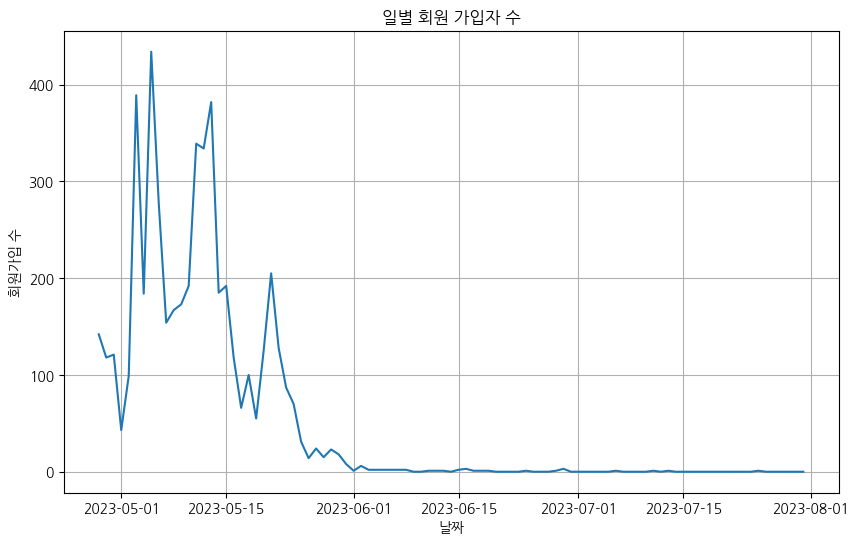

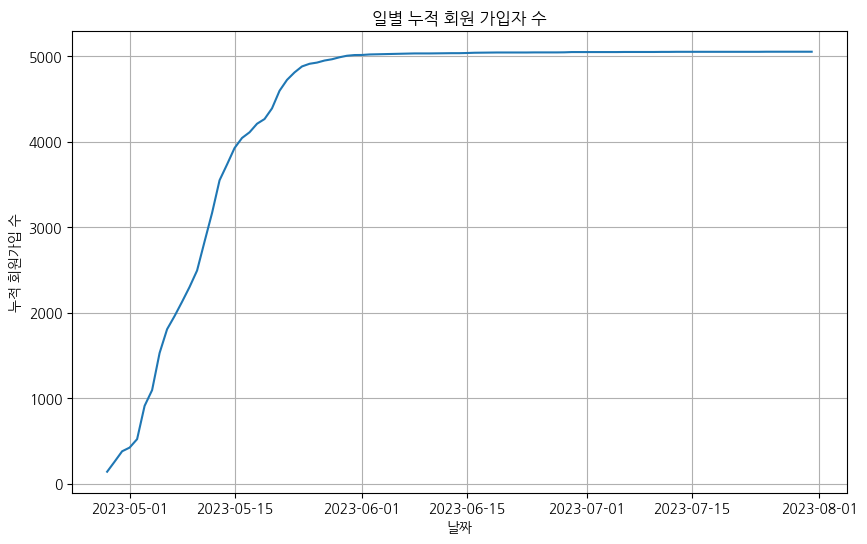

In [71]:
# 일별 회원가입자 수
plt.figure(figsize = (10,6))
sns.lineplot(data = daily_user, x = 'user_date', y = 'daily_user_count')
plt.title("일별 회원 가입자 수")
plt.xlabel('날짜')
plt.ylabel("회원가입 수")
plt.grid()
plt.show()


# 일별 누적 회원가입자 수
plt.figure(figsize = (10,6))
sns.lineplot(data = cumulative_user, x = 'user_date', y = 'cumulative_user_count')
plt.title("일별 누적 회원 가입자 수")
plt.xlabel('날짜')
plt.ylabel("누적 회원가입 수")
plt.grid()
plt.show()

## 3-4. 일별 투표 유저수

In [72]:
questionrecord_df = userquestionrecord_df.copy()

# 1. 날짜만 추출
questionrecord_df['vote_date'] = questionrecord_df['created_at'].dt.date

# 2. 일별 고유 유저 수 집계
daily_vote = (
    questionrecord_df.groupby('vote_date')['user_id']
    .nunique()
    .reset_index()
    .rename(columns={'user_id': 'daily_vote_count'})
)

# 3. 5월 1일 이후만 필터링
#daily_vote = daily_vote[daily_vote['vote_date'] >= pd.to_datetime('2023-05-01').date()]
daily_vote

,vote_date,daily_vote_count
0,2023-04-28,125
1,2023-04-29,221
2,2023-04-30,325
3,2023-05-01,325
4,2023-05-02,413
...,...,...
90,2023-07-27,14
91,2023-07-28,14
92,2023-07-29,17
93,2023-07-30,11


## 3-5. 누적 회원가입 유저 데이터 + 일별 투표 유저 데이터 merge

In [73]:
# 날짜 컬럼 이름을 통일
daily_vote_renamed = daily_vote.rename(columns={'vote_date': 'date'})
cumulative_user_renamed = cumulative_user.rename(columns={'user_date': 'date'})

# 날짜 기준 병합
ratio_df = pd.merge(daily_vote_renamed, cumulative_user_renamed, on='date', how='outer')

# 날짜 정렬
ratio_df = ratio_df.sort_values(by='date').reset_index(drop=True)
ratio_df

,date,daily_vote_count,cumulative_user_count
0,2023-04-28,125,142
1,2023-04-29,221,260
2,2023-04-30,325,381
3,2023-05-01,325,424
4,2023-05-02,413,523
...,...,...,...
90,2023-07-27,14,5052
91,2023-07-28,14,5052
92,2023-07-29,17,5052
93,2023-07-30,11,5052


In [74]:
# 날짜별 투표율 계산
ratio_df['vote_rate'] = (ratio_df['daily_vote_count'] / ratio_df['cumulative_user_count']) * 100

# 소수점 2자리까지 반올림
ratio_df['vote_rate'] = ratio_df['vote_rate'].round(2)
ratio_df[['date', 'daily_vote_count', 'cumulative_user_count', 'vote_rate']]

,date,daily_vote_count,cumulative_user_count,vote_rate
0,2023-04-28,125,142,88.03
1,2023-04-29,221,260,85.00
2,2023-04-30,325,381,85.30
3,2023-05-01,325,424,76.65
4,2023-05-02,413,523,78.97
...,...,...,...,...
90,2023-07-27,14,5052,0.28
91,2023-07-28,14,5052,0.28
92,2023-07-29,17,5052,0.34
93,2023-07-30,11,5052,0.22


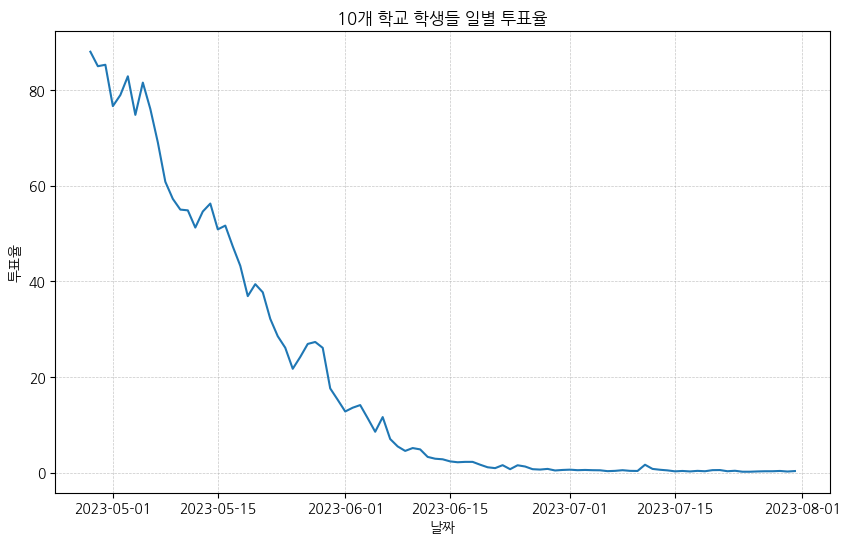

In [75]:
# 10개 학교 유저들 일별 투표율
plt.figure(figsize = (10,6))
sns.lineplot(data = ratio_df, x = 'date', y = 'vote_rate')
plt.title("10개 학교 학생들 일별 투표율")
plt.xlabel('날짜')
plt.ylabel('투표율')
plt.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.7)
plt.show()

# 4. 투표한 유저들의 리텐션

In [76]:
# 투표 날짜 컬럼 년-월-일로 생성
userquestionrecord_df = userquestionrecord_df.copy()
userquestionrecord_df['vote_date'] = userquestionrecord_df['created_at'].dt.date

In [77]:
# 각 유저별 일별 투표 수 및 순서(투표 순서)
# vote_date도 7월로 제한

#  유저별 + 날짜별 투표 수 집계
user_daily_vote_df = (
    userquestionrecord_df
    .groupby(['user_id', 'vote_date'])
    .size()
    .reset_index(name='daily_vote_count')
)
# 유저별 투표 날짜 순 정렬
user_daily_vote_df = user_daily_vote_df.sort_values(['user_id', 'vote_date'])

# 유저별로 투표 순서 번호 붙이기
user_daily_vote_df['vote_sequence'] = (
    user_daily_vote_df
    .groupby('user_id')
    .cumcount() + 1  # 0부터 시작하므로 +1
)

user_daily_vote_df

,user_id,vote_date,daily_vote_count,vote_sequence
0,838023,2023-04-29,1,1
1,838023,2023-04-30,6,2
2,838023,2023-05-02,1,3
3,838023,2023-05-03,10,4
4,838023,2023-05-04,4,5
...,...,...,...,...
50240,1579418,2023-07-25,9,1
50241,1579418,2023-07-26,17,2
50242,1579418,2023-07-28,7,3
50243,1579418,2023-07-29,7,4


### 4-1. 핵심기간 리텐션

In [79]:
# 1. first_vote_date 기준으로 코호트 날짜 설정(유저별로 첫 투표 날짜(min))
vote_df = user_daily_vote_df.copy()
vote_df['first_vote_date'] = vote_df.groupby('user_id')['vote_date'].transform('min')

# 2. 가입일 기준 n일차 계산(첫날은 0일)
vote_df['day_n'] = (pd.to_datetime(vote_df['vote_date']) - pd.to_datetime(vote_df['first_vote_date'])).dt.days

# 3. 유저 수 집계 (코호트일, day_n 기준으로 몇 명이 활동했는가)
cohort_table = (
    vote_df
    .groupby(['first_vote_date', 'day_n'])['user_id']
    .nunique()
    .reset_index()
    .rename(columns={'user_id': 'active_users'})
)

# 4. 코호트별 전체 유저 수 (Day 0 기준 유입자 수(해당 날짜가 첫 투표일임))
cohort_sizes = (
    cohort_table[cohort_table['day_n'] == 0]
    .rename(columns={'active_users': 'cohort_size'})[['first_vote_date', 'cohort_size']]
)

# 5. 병합하여 리텐션율 계산
cohort_table = cohort_table.merge(cohort_sizes, on='first_vote_date')
cohort_table['retention_rate'] = (cohort_table['active_users'] / cohort_table['cohort_size'] * 100).round(2)

# 6. 피벗 테이블 변환
cohort_retention = cohort_table.pivot(index='first_vote_date', columns='day_n', values='retention_rate')
cohort_retention

day_n,0,1,2,3,4,5,6,7,8,9,...,85,86,87,88,89,90,91,92,93,94
first_vote_date,,,,,,,,,,,,,,,,,,,,,
2023-04-28,100.0,97.60,90.40,80.80,90.40,72.00,61.60,60.00,56.00,48.80,...,0.80,0.80,NaN,NaN,NaN,NaN,1.60,2.40,NaN,0.8
2023-04-29,100.0,98.99,85.86,89.90,83.84,67.68,63.64,64.65,51.52,45.45,...,NaN,NaN,3.03,NaN,NaN,NaN,NaN,1.01,1.01,NaN
2023-04-30,100.0,90.35,94.74,89.47,69.30,70.18,71.93,57.02,52.63,54.39,...,NaN,1.75,1.75,0.88,0.88,NaN,NaN,0.88,NaN,NaN
2023-05-01,100.0,86.11,83.33,63.89,72.22,55.56,63.89,58.33,44.44,30.56,...,NaN,NaN,NaN,NaN,NaN,2.78,2.78,NaN,NaN,NaN
2023-05-02,100.0,94.44,83.33,83.33,83.33,81.94,62.50,56.94,56.94,43.06,...,1.39,NaN,NaN,2.78,NaN,1.39,NaN,NaN,NaN,NaN
2023-05-03,100.0,90.60,92.17,87.73,82.25,68.41,60.84,50.13,42.30,33.16,...,NaN,NaN,NaN,NaN,0.78,NaN,NaN,NaN,NaN,NaN
2023-05-04,100.0,92.81,90.42,83.83,63.47,55.69,49.70,41.92,33.53,23.95,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-05-05,100.0,93.81,85.78,75.92,59.40,56.88,43.81,37.61,31.65,33.49,...,NaN,0.23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-05-06,100.0,88.52,81.42,71.04,57.38,54.10,38.25,35.52,32.79,24.59,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [80]:
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", ['#f7f7f7', '#009688',  '#ffc107'])

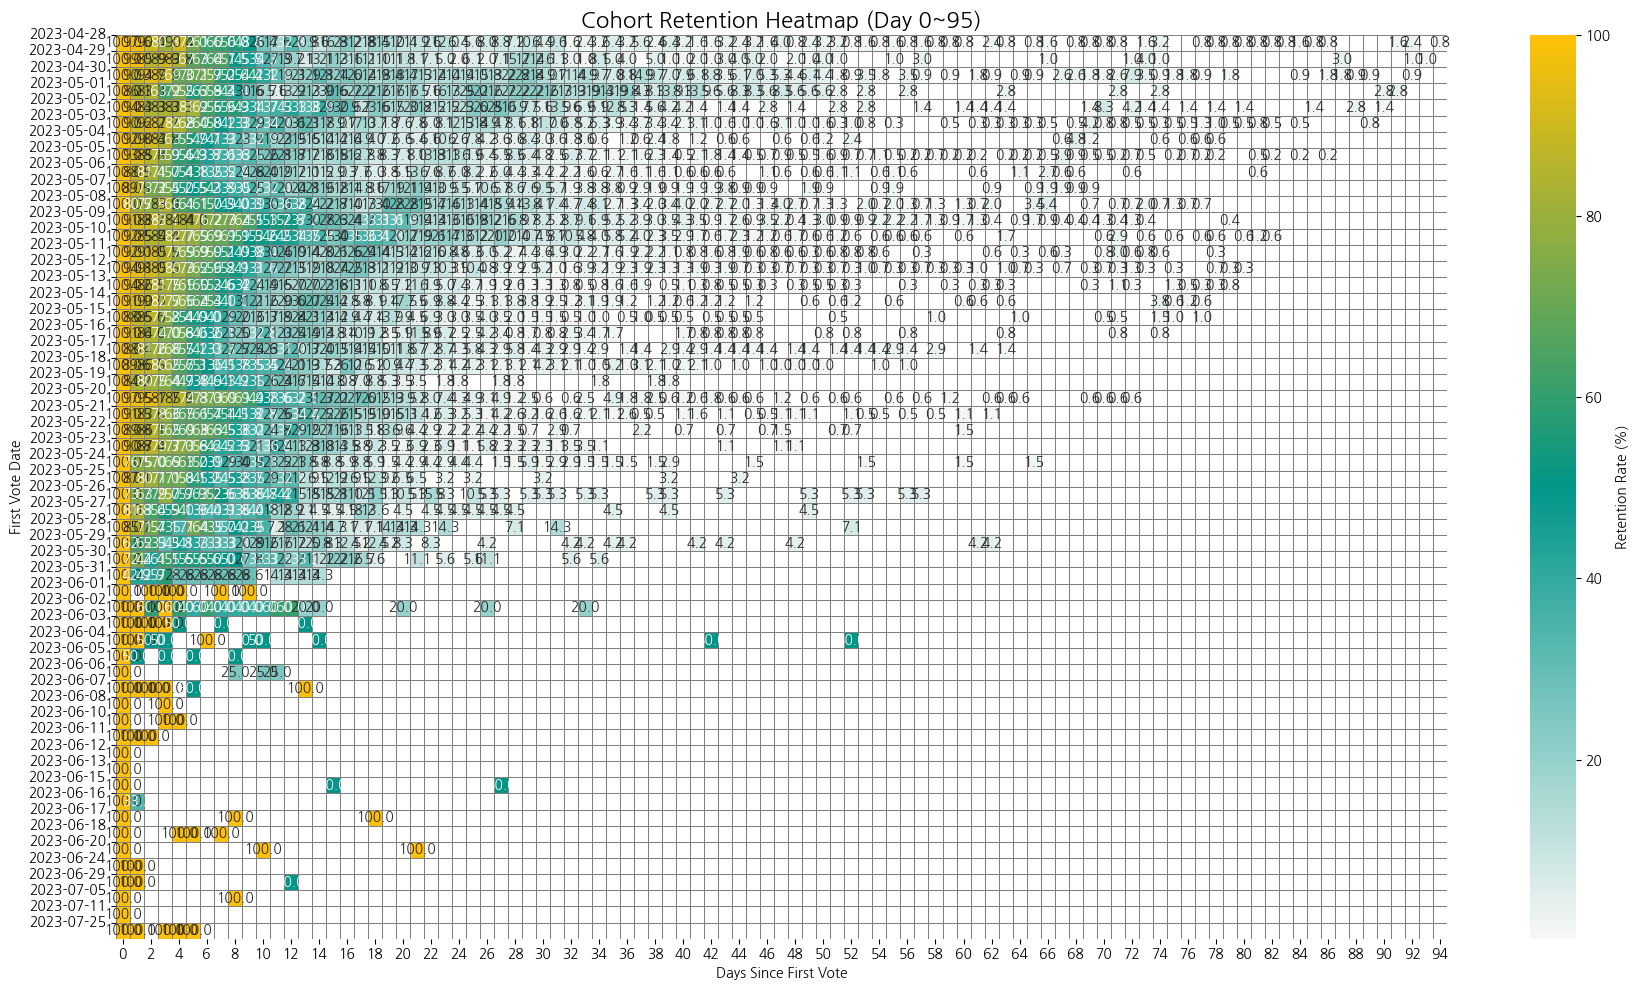

In [81]:
# 1. 날짜 인덱스 → datetime 포맷 유지 (y축 레이블 위해 필요)
cohort_retention.index = pd.to_datetime(cohort_retention.index)

# 2. 0~95일 사이 day_n만 필터링
cohort_retention = cohort_retention[[col for col in cohort_retention.columns if isinstance(col, int) and col <= 95]]

# 3. 히트맵 시각화
plt.figure(figsize=(18, 10))
sns.heatmap(
    cohort_retention,
    annot=True,
    fmt=".1f",
    cmap=custom_cmap,
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={'label': 'Retention Rate (%)'}
)

# 4. 강제로 모든 y축 날짜 레이블 표시
plt.yticks(
    ticks=range(len(cohort_retention.index)),
    labels=cohort_retention.index.strftime('%Y-%m-%d'),
    rotation=0
)

# 5. 제목, 라벨 설정
plt.title("Cohort Retention Heatmap (Day 0~95)", fontsize=16)
plt.xlabel("Days Since First Vote")
plt.ylabel("First Vote Date")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [83]:
#  cohort_sizes의 first_vote_date 데이터 타입 변환
cohort_sizes['first_vote_date'] = pd.to_datetime(cohort_sizes['first_vote_date'])

# 1. cohort_retention의 index도 datetime 형식으로 재확인
cohort_retention.index = pd.to_datetime(cohort_retention.index)

# 2. cohort_sizes를 index로 변환
cohort_sizes_indexed = cohort_sizes.set_index('first_vote_date')

# 3. 병합 (index 기준)
retention = pd.concat([cohort_retention, cohort_sizes_indexed], axis=1)

# 4. 날짜 컬럼 순서 정리
day_cols = sorted([col for col in retention.columns if isinstance(col, int)])
final_cols = ['cohort_size'] + day_cols
retention = retention[final_cols]
retention

,cohort_size,0,1,2,3,4,5,6,7,8,...,85,86,87,88,89,90,91,92,93,94
first_vote_date,,,,,,,,,,,,,,,,,,,,,
2023-04-28,125,100.0,97.60,90.40,80.80,90.40,72.00,61.60,60.00,56.00,...,0.80,0.80,NaN,NaN,NaN,NaN,1.60,2.40,NaN,0.8
2023-04-29,99,100.0,98.99,85.86,89.90,83.84,67.68,63.64,64.65,51.52,...,NaN,NaN,3.03,NaN,NaN,NaN,NaN,1.01,1.01,NaN
2023-04-30,114,100.0,90.35,94.74,89.47,69.30,70.18,71.93,57.02,52.63,...,NaN,1.75,1.75,0.88,0.88,NaN,NaN,0.88,NaN,NaN
2023-05-01,36,100.0,86.11,83.33,63.89,72.22,55.56,63.89,58.33,44.44,...,NaN,NaN,NaN,NaN,NaN,2.78,2.78,NaN,NaN,NaN
2023-05-02,72,100.0,94.44,83.33,83.33,83.33,81.94,62.50,56.94,56.94,...,1.39,NaN,NaN,2.78,NaN,1.39,NaN,NaN,NaN,NaN
2023-05-03,383,100.0,90.60,92.17,87.73,82.25,68.41,60.84,50.13,42.30,...,NaN,NaN,NaN,NaN,0.78,NaN,NaN,NaN,NaN,NaN
2023-05-04,167,100.0,92.81,90.42,83.83,63.47,55.69,49.70,41.92,33.53,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-05-05,436,100.0,93.81,85.78,75.92,59.40,56.88,43.81,37.61,31.65,...,NaN,0.23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-05-06,183,100.0,88.52,81.42,71.04,57.38,54.10,38.25,35.52,32.79,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 4-2. 핵심 기간 동안 날짜 코호스별 유저 수 변화

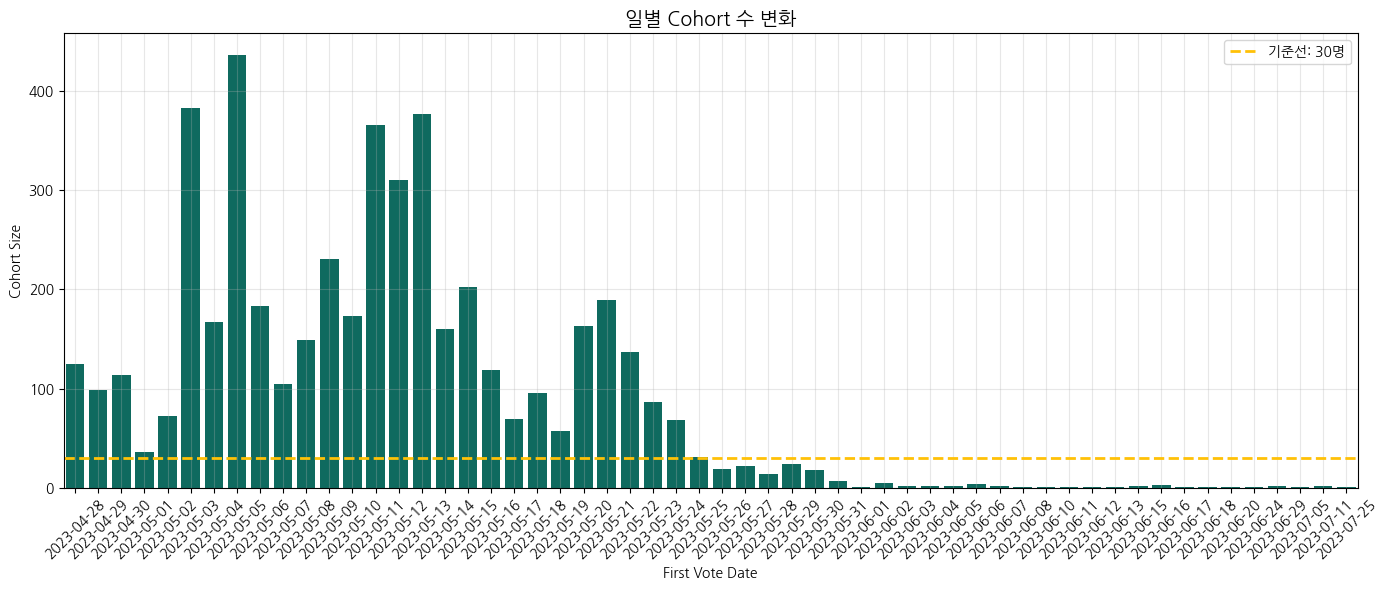

In [ ]:
# 코호트 유저수 변화 확인

# 1. 날짜 컬럼 초기화
cohort_size_df = retention[['cohort_size']].copy()
cohort_size_df.index = pd.to_datetime(cohort_size_df.index)
cohort_size_df = cohort_size_df.reset_index().rename(columns={'index': 'first_vote_date'})

# 2. 시각화
plt.figure(figsize=(14, 6))
sns.barplot(data=cohort_size_df, x='first_vote_date', y='cohort_size', color='#00796B')

# 3. 기준선 추가
plt.axhline(y=30, color='#FFC107', linestyle='--', linewidth=2, label='기준선: 30명')

# 4. x축 날짜 형식 및 간격 설정
ax = plt.gca()
# ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))  # 5일 간격
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)

# 5. 그래프
plt.title("일별 Cohort 수 변화", fontsize=14)
plt.xlabel("First Vote Date")
plt.ylabel("Cohort Size")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


### 4-3. 코호트 유저 수 30명 이상 필터링

In [85]:
# 1. cohort_size가 30 이상인 cohort만 남기기
retention = retention[retention['cohort_size'] >= 30]

# 2. day_n이 30 이하인 컬럼만 남기기
filtered_day_cols = [col for col in day_cols if col <= 30]
final_cols = ['cohort_size'] + filtered_day_cols
retention = retention[final_cols]

# 분석에 이용 할 리텐션 기간 : 2023-04-29 ~ 2023-05-25
retention

,cohort_size,0,1,2,3,4,5,6,7,8,...,21,22,23,24,25,26,27,28,29,30
first_vote_date,,,,,,,,,,,,,,,,,,,,,
2023-04-28,125,100.0,97.60,90.40,80.80,90.40,72.00,61.60,60.00,56.00,...,11.20,9.60,12.00,6.40,5.60,8.00,8.80,7.20,10.40,6.40
2023-04-29,99,100.0,98.99,85.86,89.90,83.84,67.68,63.64,64.65,51.52,...,8.08,7.07,5.05,2.02,6.06,2.02,7.07,15.15,17.17,14.14
2023-04-30,114,100.0,90.35,94.74,89.47,69.30,70.18,71.93,57.02,52.63,...,17.54,13.16,14.04,14.91,14.04,15.79,13.16,22.81,22.81,14.04
2023-05-01,36,100.0,86.11,83.33,63.89,72.22,55.56,63.89,58.33,44.44,...,16.67,5.56,16.67,13.89,25.00,22.22,16.67,22.22,22.22,22.22
2023-05-02,72,100.0,94.44,83.33,83.33,83.33,81.94,62.50,56.94,56.94,...,20.83,12.50,12.50,12.50,23.61,20.83,25.00,16.67,9.72,5.56
2023-05-03,383,100.0,90.60,92.17,87.73,82.25,68.41,60.84,50.13,42.30,...,7.83,6.01,8.09,12.53,13.84,14.36,9.66,8.09,6.79,10.97
2023-05-04,167,100.0,92.81,90.42,83.83,63.47,55.69,49.70,41.92,33.53,...,5.39,6.59,10.18,6.59,7.78,4.19,3.59,3.59,8.38,2.99
2023-05-05,436,100.0,93.81,85.78,75.92,59.40,56.88,43.81,37.61,31.65,...,8.03,13.76,13.07,13.07,6.88,6.42,5.50,8.49,6.42,4.82
2023-05-06,183,100.0,88.52,81.42,71.04,57.38,54.10,38.25,35.52,32.79,...,13.66,6.56,8.74,6.01,8.20,2.19,6.01,4.37,3.28,4.37


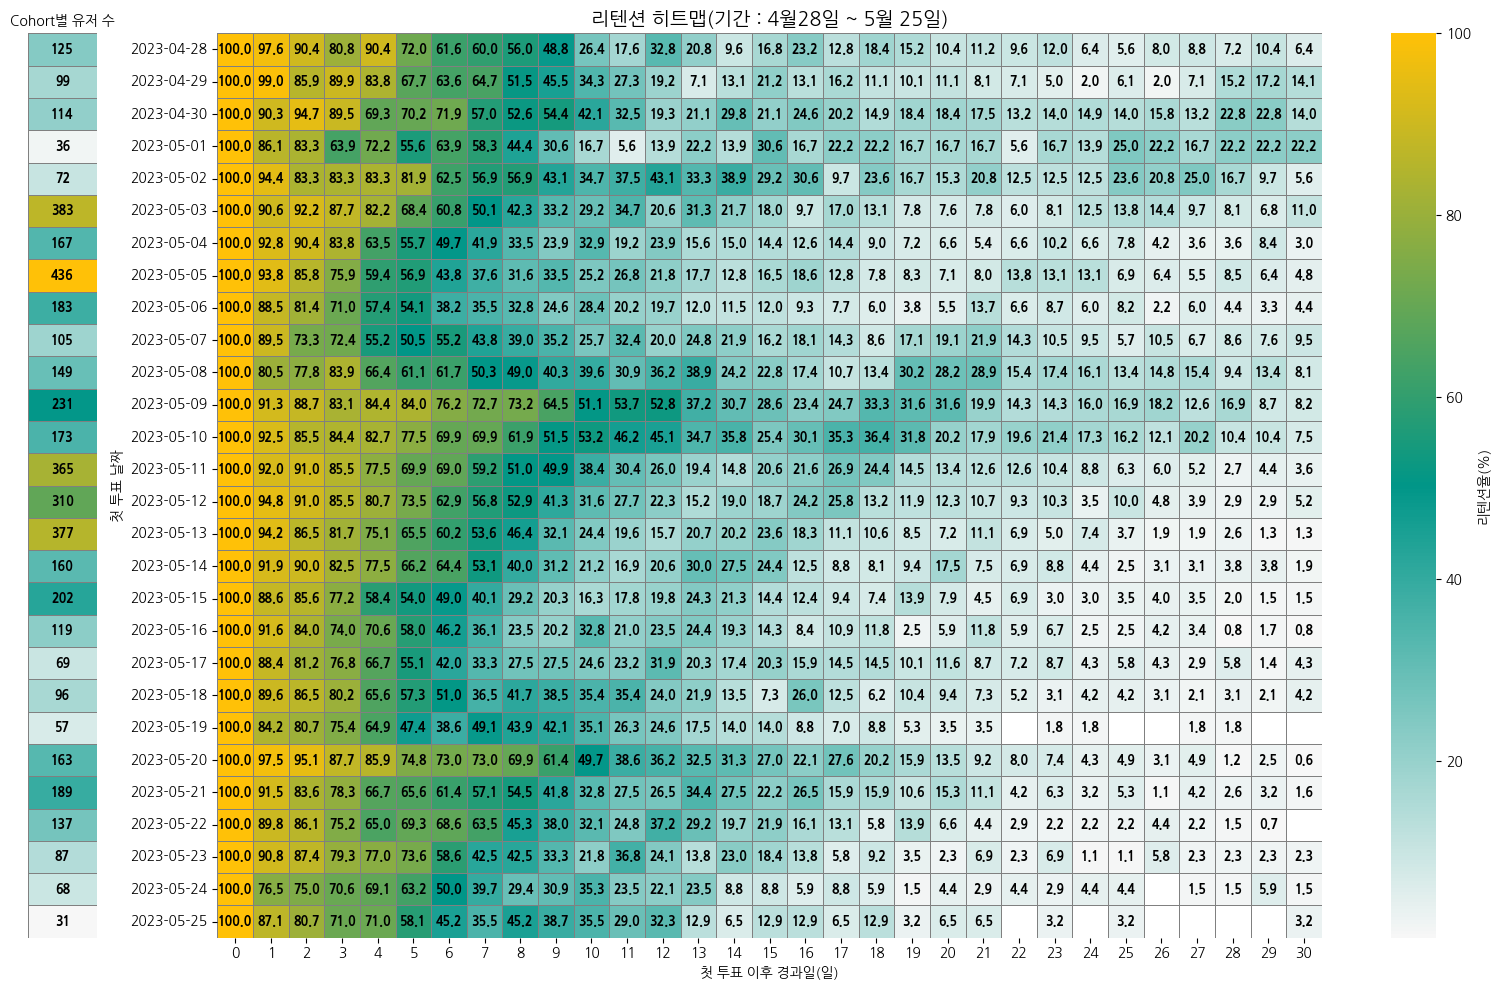

In [86]:
# 1. 인덱스 문자열 통일
retention.index = pd.to_datetime(retention.index)
retention.index = retention.index.strftime('%Y-%m-%d')

# 2. 데이터 분리
cohort_sizes = pd.DataFrame(retention['cohort_size'])
cohort_sizes.columns = ['Cohort Size']
heatmap_data = retention.drop(columns='cohort_size')

# 3. 서브플롯 구성
fig, (ax0, ax1) = plt.subplots(
    ncols=2,
    figsize=(16, 10),
    gridspec_kw={'width_ratios': [0.3, 6]} 
)

# 4. Cohort Size 히트맵
sns.heatmap(
    cohort_sizes,
    ax=ax0,
    annot=True, fmt="d", cmap=custom_cmap,
    annot_kws={"weight": "bold","color": "black", "size": 9},
    linewidths=0.5, linecolor='gray',
    cbar=False,
    yticklabels=False,
    xticklabels=False
)
ax0.set_ylabel("")
ax0.set_xlabel("")
ax0.set_title("Cohort별 유저 수", fontsize=10)

# 5. Retention 히트맵
sns.heatmap(
    heatmap_data,
    ax=ax1,
    annot=True, fmt=".1f", cmap=custom_cmap,
    annot_kws={"weight": "bold", "color": "black", "size": 9},
    linewidths=0.5, linecolor='gray',
    cbar_kws={'label': '리텐션율(%)'}
)
ax1.set_title("리텐션 히트맵(기간 : 4월28일 ~ 5월 25일)", fontsize=14)
ax1.set_xlabel("첫 투표 이후 경과일(일)")
ax1.set_ylabel("첫 투표 날짜")
ax1.set_yticklabels(ax1.get_yticklabels(), rotation=0)
plt.tight_layout()
plt.show()

### 4-4. n-day별 평균 리텐션

In [87]:
# cohort_size 제외한 day_n 컬럼만 선택
day_cols = [col for col in retention.columns if isinstance(col, int)]

# 각 day_n별 평균 리텐션율 계산
average_retention = retention[day_cols].mean()
average_retention

0     100.000000
1      90.560357
2      85.612143
3      79.663571
4      72.211786
5      64.533571
6      57.838571
7      51.003571
8      45.276429
9      38.432143
10     32.383214
11     27.972857
12     26.966429
13     23.450714
14     20.098929
15     19.337857
16     17.591071
17     15.086071
18     14.028929
19     12.499286
20     11.959643
21     11.300357
22      8.743077
23      8.953571
24      7.481852
25      8.253704
26      7.893200
27      7.150741
28      6.980741
29      6.956923
30      5.800000
dtype: float64

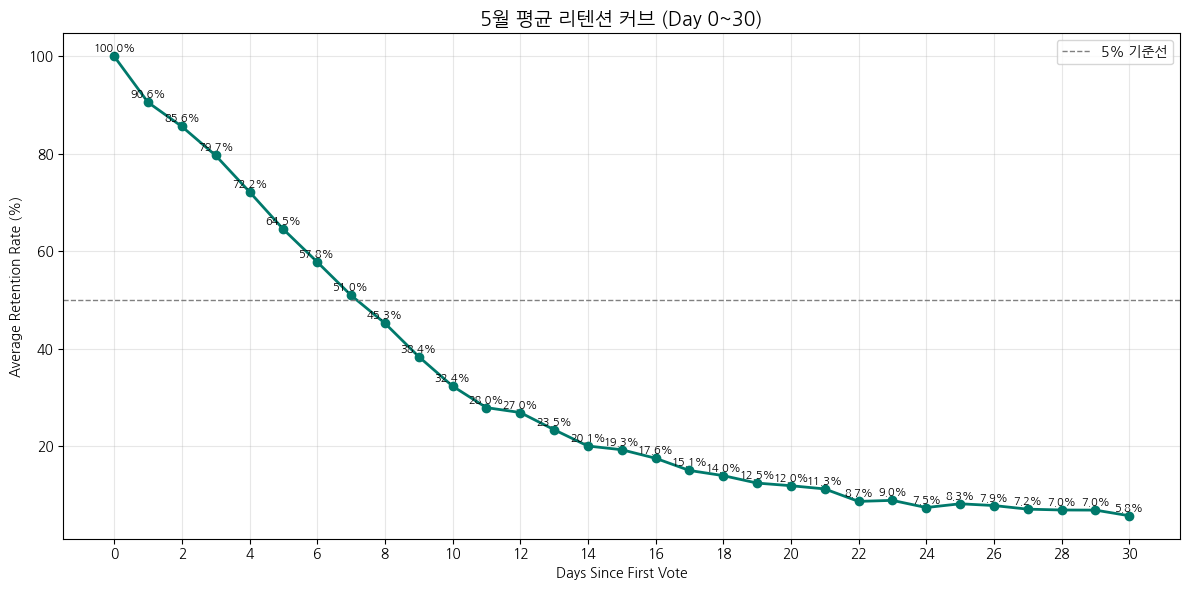

In [88]:
plt.figure(figsize=(12, 6))
plt.plot(average_retention.index, average_retention.values, marker='o', color='#00796B', linewidth=2)

# 마커 위에 값 표시
for x, y in zip(average_retention.index, average_retention.values):
    plt.text(x, y + 1, f'{y:.1f}%', ha='center', fontsize=8)  

# 기준선
plt.axhline(y=50, color='gray', linestyle='--', linewidth=1, label='5% 기준선')

plt.title('5월 평균 리텐션 커브 (Day 0~30)', fontsize=14)
plt.xlabel('Days Since First Vote')
plt.ylabel('Average Retention Rate (%)')
plt.xticks(range(0, 31, 2))
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# 5. 상하위 25% 리텐션 유저 추출

## 5-1. 리텐션 해당 유저 추출

In [89]:
vote_df

,user_id,vote_date,daily_vote_count,vote_sequence,first_vote_date,day_n
0,838023,2023-04-29,1,1,2023-04-29,0
1,838023,2023-04-30,6,2,2023-04-29,1
2,838023,2023-05-02,1,3,2023-04-29,3
3,838023,2023-05-03,10,4,2023-04-29,4
4,838023,2023-05-04,4,5,2023-04-29,5
...,...,...,...,...,...,...
50240,1579418,2023-07-25,9,1,2023-07-25,0
50241,1579418,2023-07-26,17,2,2023-07-25,1
50242,1579418,2023-07-28,7,3,2023-07-25,3
50243,1579418,2023-07-29,7,4,2023-07-25,4


In [90]:
# 1. first_vote_date 타입 datetime 변환
vote_df['first_vote_date'] = pd.to_datetime(vote_df['first_vote_date'])

# 2. 대상 기간 설정
start_date = pd.to_datetime('2023-04-28')
end_date = pd.to_datetime('2023-05-25')

# 3. 해당 기간에 첫 투표한 유저들의 활동 데이터 추출
cohort_user = vote_df[
    (vote_df['first_vote_date'] >= start_date) &
    (vote_df['first_vote_date'] <= end_date)
].copy()

# 4. 날짜별 유니크 유저 수 확인 (optional)
unique_counts = (
    cohort_user.groupby('first_vote_date')['user_id']
    .nunique()
    .reset_index(name='unique_user_count')
)

# 유니크 유저 수 출력
for _, row in unique_counts.iterrows():
    print(f"{row['first_vote_date'].date()} 유니크 유저 수: {row['unique_user_count']}")

2023-04-28 유니크 유저 수: 125
2023-04-29 유니크 유저 수: 99
2023-04-30 유니크 유저 수: 114
2023-05-01 유니크 유저 수: 36
2023-05-02 유니크 유저 수: 72
2023-05-03 유니크 유저 수: 383
2023-05-04 유니크 유저 수: 167
2023-05-05 유니크 유저 수: 436
2023-05-06 유니크 유저 수: 183
2023-05-07 유니크 유저 수: 105
2023-05-08 유니크 유저 수: 149
2023-05-09 유니크 유저 수: 231
2023-05-10 유니크 유저 수: 173
2023-05-11 유니크 유저 수: 365
2023-05-12 유니크 유저 수: 310
2023-05-13 유니크 유저 수: 377
2023-05-14 유니크 유저 수: 160
2023-05-15 유니크 유저 수: 202
2023-05-16 유니크 유저 수: 119
2023-05-17 유니크 유저 수: 69
2023-05-18 유니크 유저 수: 96
2023-05-19 유니크 유저 수: 57
2023-05-20 유니크 유저 수: 163
2023-05-21 유니크 유저 수: 189
2023-05-22 유니크 유저 수: 137
2023-05-23 유니크 유저 수: 87
2023-05-24 유니크 유저 수: 68
2023-05-25 유니크 유저 수: 31


In [91]:
# 4월 29일 첫 투표 유저 ~ 5월 25일 첫 투표 유저 추출
cohort_user = cohort_user[['user_id', 'first_vote_date']]
cohort_user = cohort_user.drop_duplicates(subset = 'user_id').reset_index(drop = True)
cohort_user

,user_id,first_vote_date
0,838023,2023-04-29
1,838466,2023-05-02
2,838642,2023-04-28
3,839357,2023-04-29
4,840293,2023-05-03
...,...,...
4698,1510561,2023-05-25
4699,1511957,2023-05-25
4700,1512422,2023-05-25
4701,1512542,2023-05-25


In [92]:
# 1. 분위수 계산
q25 = retention[8].quantile(0.25)
q75 = retention[8].quantile(0.75)

# 2. 하위 25%에 해당하는 코호트 날짜
bottom_25_dates = retention[retention[8] <= q25].reset_index()

# 3. 상위 25%에 해당하는 코호트 날짜
top_25_dates = retention[retention[8] >= q75].reset_index()

# 4. 출력 (선택)
print("8일차 리텐션 하위 25% 코호트 날짜:")
display(bottom_25_dates)

print("8일차 리텐션 상위 25% 코호트 날짜:")
display(top_25_dates)

8일차 리텐션 하위 25% 코호트 날짜:


,first_vote_date,cohort_size,0,1,2,3,4,5,6,7,...,21,22,23,24,25,26,27,28,29,30
0,2023-05-04,167,100.0,92.81,90.42,83.83,63.47,55.69,49.70,41.92,...,5.39,6.59,10.18,6.59,7.78,4.19,3.59,3.59,8.38,2.99
1,2023-05-05,436,100.0,93.81,85.78,75.92,59.40,56.88,43.81,37.61,...,8.03,13.76,13.07,13.07,6.88,6.42,5.50,8.49,6.42,4.82
2,2023-05-06,183,100.0,88.52,81.42,71.04,57.38,54.10,38.25,35.52,...,13.66,6.56,8.74,6.01,8.20,2.19,6.01,4.37,3.28,4.37
3,2023-05-15,202,100.0,88.61,85.64,77.23,58.42,53.96,49.01,40.10,...,4.46,6.93,2.97,2.97,3.47,3.96,3.47,1.98,1.49,1.49
4,2023-05-16,119,100.0,91.60,84.03,73.95,70.59,57.98,46.22,36.13,...,11.76,5.88,6.72,2.52,2.52,4.20,3.36,0.84,1.68,0.84
5,2023-05-17,69,100.0,88.41,81.16,76.81,66.67,55.07,42.03,33.33,...,8.70,7.25,8.70,4.35,5.80,4.35,2.90,5.80,1.45,4.35
6,2023-05-24,68,100.0,76.47,75.00,70.59,69.12,63.24,50.00,39.71,...,2.94,4.41,2.94,4.41,4.41,NaN,1.47,1.47,5.88,1.47


8일차 리텐션 상위 25% 코호트 날짜:


,first_vote_date,cohort_size,0,1,2,3,4,5,6,7,...,21,22,23,24,25,26,27,28,29,30
0,2023-04-28,125,100.0,97.60,90.40,80.80,90.40,72.00,61.60,60.00,...,11.20,9.60,12.00,6.40,5.60,8.00,8.80,7.20,10.40,6.40
1,2023-05-02,72,100.0,94.44,83.33,83.33,83.33,81.94,62.50,56.94,...,20.83,12.50,12.50,12.50,23.61,20.83,25.00,16.67,9.72,5.56
2,2023-05-09,231,100.0,91.34,88.74,83.12,84.42,83.98,76.19,72.73,...,19.91,14.29,14.29,16.02,16.88,18.18,12.55,16.88,8.66,8.23
3,2023-05-10,173,100.0,92.49,85.55,84.39,82.66,77.46,69.94,69.94,...,17.92,19.65,21.39,17.34,16.18,12.14,20.23,10.40,10.40,7.51
4,2023-05-12,310,100.0,94.84,90.97,85.48,80.65,73.55,62.90,56.77,...,10.65,9.35,10.32,3.55,10.00,4.84,3.87,2.90,2.90,5.16
5,2023-05-20,163,100.0,97.55,95.09,87.73,85.89,74.85,73.01,73.01,...,9.20,7.98,7.36,4.29,4.91,3.07,4.91,1.23,2.45,0.61
6,2023-05-21,189,100.0,91.53,83.60,78.31,66.67,65.61,61.38,57.14,...,11.11,4.23,6.35,3.17,5.29,1.06,4.23,2.65,3.17,1.59


In [93]:
# 각 그룹의 cohort_size 합 -> 25% 이상 한명이 부족함 1253명임
under_25_total = bottom_25_dates['cohort_size'].sum()
over_25_total = top_25_dates['cohort_size'].sum()

print(f"8일차 리텐션이 25% 이하인 그룹의 전체 cohort_size 합: {under_25_total}")
print(f"8일차 리텐션이 25% 이상인 그룹의 전체 cohort_size 합: {over_25_total}")

8일차 리텐션이 25% 이하인 그룹의 전체 cohort_size 합: 1244
8일차 리텐션이 25% 이상인 그룹의 전체 cohort_size 합: 1263
